In [1]:
#Initate connectiong to spark
from pyspark.sql import SparkSession

spark_session = SparkSession\
        .builder\
        .master("spark://192.168.2.74:7077") \
        .appName("Freq_Plot_func")\
        .config("spark.dynamicAllocation.enabled", True)\
        .config("spark.dynamicAllocation.shuffleTracking.enabled",True)\
        .config("spark.shuffle.service.enabled", False)\
        .config("spark.dynamicAllocation.executorIdleTimeout","30s")\
        .config("spark.executor.cores",2)\
        .config("spark.driver.port",9998)\
        .config("spark.blockManager.port",10005)\
        .getOrCreate()

spark_context = spark_session.sparkContext

spark_context.setLogLevel("ERROR")

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/03/14 16:11:55 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/03/14 16:11:58 WARN ExecutorAllocationManager: Dynamic allocation without a shuffle service is an experimental feature.


In [2]:
#load files here 
rides = spark_session.read\
    .option("header", "true")\
    .csv('hdfs://192.168.2.74:9000/user/ubuntu/uber-tlc-foil-response/uber-trip-data/uber-raw-data-apr14.csv')\
    .cache()

In [3]:
import pyspark.sql.functions as F
from pyspark.sql.types import *
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt 
from shapely.geometry import Point, Polygon
#function to run all 
def plotwfreq(rides,dataname):
    #

    # remortamt Date/time to -> Month , day , hour 
    #The date given is M/D/Y , we use F.split to split the text string from Date/Time based on delimeter thus creating an "list" and picking relevant item, note that hour requires several Split.

    df1 = rides.withColumn('year', F.split(F.split(rides['Date/Time'], '/').getItem(2),' ').getItem(0)) \
           .withColumn('month', F.split(rides['Date/Time'], '/').getItem(0)) \
           .withColumn('day', F.split(rides['Date/Time'], '/').getItem(1)) \
           .withColumn('hour', F.split(F.split(F.split(rides['Date/Time'], '/').getItem(2),' ').getItem(1),':').getItem(0)) \
           .withColumn('minute', F.split(F.split(F.split(rides['Date/Time'], '/').getItem(2),' ').getItem(1),':').getItem(1)) \


    df1 = df1.select([F.col(c).cast('integer') if c in ['year','month','day','hour','minute'] else c for c in df1.columns]) #casts as integer. 
    df1=df1.withColumn('weekday',F.date_format(F.concat(F.col("year"),F.lit("-"),F.col("month"),F.lit("-"),F.col("day")),'E'))
    
    #
    #Creating a table with #Day #Hour #weekday #ride_count

    hour_rides = df1.select('year','month','weekday','day','hour')

    # Checking what times of the day for weekdays troughout the month 
    hour_rides_count = hour_rides.groupBy('year','month','weekday','hour').count()
    hour_count = hour_rides.groupBy('hour').count().sort('hour')
    weekday_count = hour_rides.groupBy('weekday').count().sort('weekday')
    
    #load to pandas dataframe 

    #Get values from DF previous and plot them 
    hour_pandasDF = hour_count.toPandas()
    plt.bar(hour_pandasDF['hour'],hour_pandasDF['count'])
    plt.title(f'Uber Driver {dataname}')
    plt.ylabel(f'Total hours driven')
    plt.ylabel(f'Hour of day')
    plt.xticks(hour_pandasDF['hour'])
    plt.show()

    #Plot weekdays 
    weekday_pandasDF = weekday_count.toPandas()
    plt.bar(weekday_pandasDF['weekday'],weekday_pandasDF['count'])
    plt.title(f'Uber Driver {dataname}')
    plt.ylabel(f'Total hours driven')
    plt.ylabel(f'Frequenices')
    plt.xticks(weekday_pandasDF['weekday'])
    plt.show()
    
    #Weekday hourly averages

    wh_avg = hour_rides.groupBy('day','hour','weekday').count()
    wh_avg_pandas = wh_avg.toPandas() #converting to pandas 


    #Taking the average for a better plot  
    wh_avg_pandas = wh_avg_pandas.groupby(['weekday','hour'])['count'].mean() #average of weekday,hour

    wh_avg_pandas = wh_avg_pandas.reset_index()
    wh_avg_pandas = wh_avg_pandas.rename(columns = {'count':'count_avg'})
    wh_avg_pandas.head(20)

    
    ## create figure
    fig = plt.figure(figsize=(12,6))
    ax = fig.add_subplot(1,1,1)

    sns.pointplot( x='hour',y='count_avg',hue='weekday', data = wh_avg_pandas)

    ## format plot labels
    ax.set_title(f'Weekday Averages for {dataname}');ax.set_ylabel('Rides per Hour');ax.set_xlabel('Hour')

    
    
    ########### plot map (takes long time) 
    
    geo_plot = df1.select(['Lat','Lon'])
    geo_plot = geo_plot.select([F.col(c).cast('float') if c in ['Lat','Lon'] else c for c in geo_plot.columns]) #casts as float. 
    # collecting the max and min values of loat and lon. 
    lat_max = geo_plot.agg({"Lat": "max"}).collect()[0][0]
    lon_max = geo_plot.agg({"Lon": "max"}).collect()[0][0]
    lat_min = geo_plot.agg({"Lat": "min"}).collect()[0][0]
    lon_min = geo_plot.agg({"Lon": "min"}).collect()[0][0]
    
    dwr = gpd.read_file('/home/ubuntu/client/plot/geo_export.shp')
    geo_df = geo_plot.toPandas()

    # designate coordinate system
    coordsys = {'init':'epsg:4326'}
    # zip x and y coordinates into single feature
    geom = [Point(xy) for xy in zip(geo_df['Lon'], geo_df['Lat'])]
    # create GeoPandas dataframe
    geo_df = gpd.GeoDataFrame(geo_df,crs = coordsys,geometry = geom)

    #plot
    fig,ax = plt.subplots(figsize=(10,10))
    dwr.plot(ax=ax, color ='grey')
    geo_df.plot(ax=ax,alpha=0.02,color='red')
    plt.show()



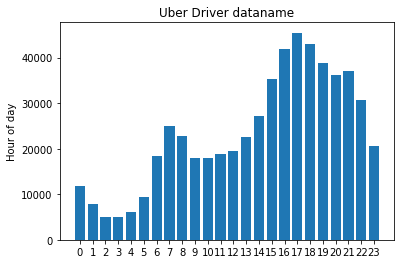

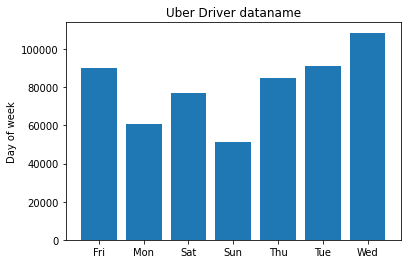

/home/ubuntu/.local/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


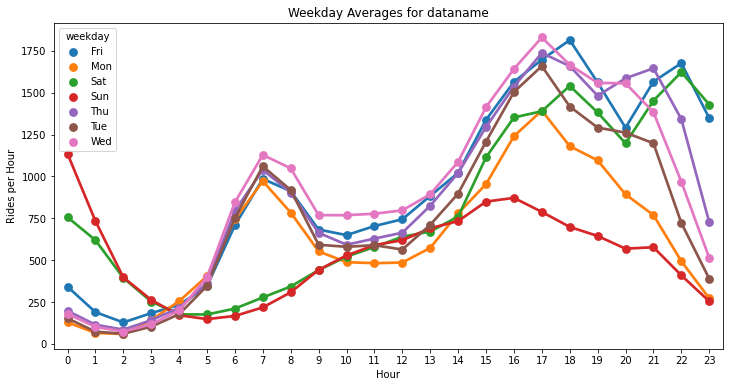

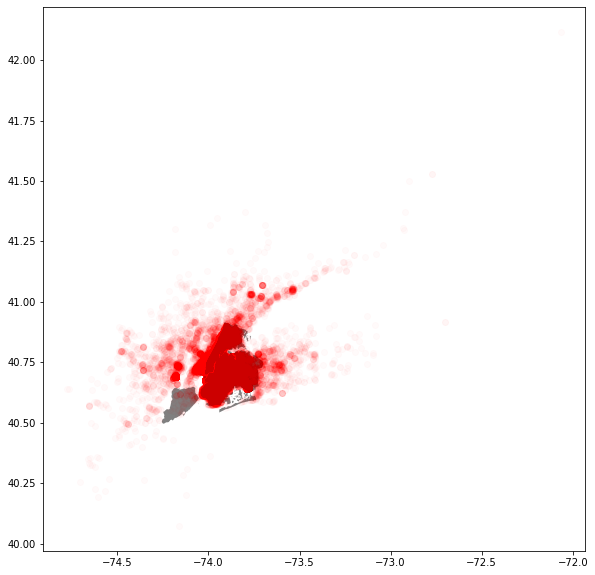

In [4]:
plotwfreq(rides,'dataname')